identifying Numbers

In [3]:
import torch                    ## import torch library for tensor computations and deep learning
import torch.nn as nn           ## import torch.nn module for building neural networks
import torchvision              ## import torchvision for computer vision tasks and datasets
import torch.nn.functional as F ## import functional module for activation functions and loss functions
import numpy as np              ## import numpy for numerical computations
import matplotlib.pyplot as plt ## import matplotlib for plotting and visualization
from sklearn import cluster, datasets, mixture  ## import sklearn modules for clustering and mixture models
from IPython.display import clear_output ## import clear_output for clearing Jupyter notebook output
import time                     ## import time module for measuring execution time
import seaborn as sns           ## import seaborn for statistical data visualization
from tqdm.auto import tqdm      ## import tqdm for progress bars

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
## set device to GPU if available, else CPU
print(f'Using device: {device}')

Using device: cpu


In [ ]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]) 
## define a transform to normalize the data | Convert 0 to 255 images to 0 to 1 and then normalize to -1 to 1
## Download MNIST dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.68MB/s]
100%|██████████| 28.9k/28.9k [00:01<00:00, 16.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.72MB/s]


In [5]:
dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

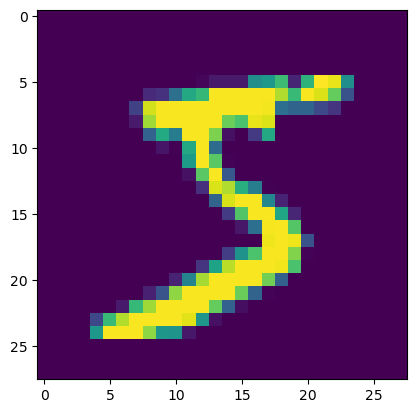

In [12]:
plt.imshow(dataset[0][0].squeeze())

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([0, 8, 7, 6, 6, 9, 4, 2, 7, 3, 1, 2, 5, 2, 5, 5, 9, 9, 0, 4, 3, 1, 7, 7,
        1, 1, 6, 0, 5, 5, 3, 2, 7, 1, 1, 0, 6, 4, 7, 6, 9, 0, 3, 8, 2, 9, 6, 9,
        1, 6, 1, 8, 3, 0, 6, 1, 1, 4, 2, 0, 4, 3, 2, 8])


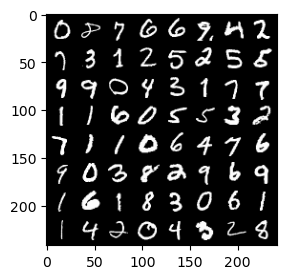

In [17]:
from torch.utils.data import DataLoader 
## import DataLoader for batching and shuffling data
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True) 
## create DataLoader for training data with batch size 64 and shuffling

x, y = next(iter(train_dataloader)) ## get a batch of data
print('Input shape:', x.shape)
print('Labels:', y)

plt.figure(figsize=(10,3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1,2,0).numpy()) 
## unnormalize and plot the batch of images
plt.show()

In [ ]:
x.shape ## check the shape of the input data 
## batch size 64 x 1 channel x 28 height x 28 width 

torch.Size([64, 1, 28, 28])

# Forward Diffusion Process

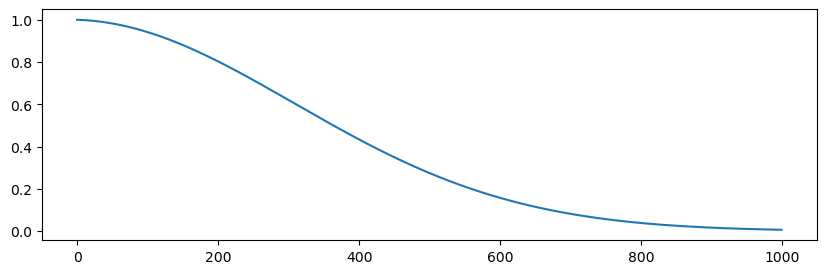

In [24]:
T = 1000
betas = torch.linspace(1e-4,0.01,T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0)

# plot the alpha bars
plt.figure(figsize=(10,3))
plt.plot(alpha_bars)
plt.show()

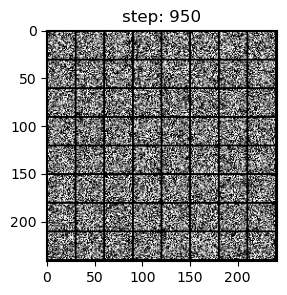

In [37]:
# Start the forward diffusion process

x=x.to(device)

for t in range(T):
    noise = torch.randn_like(x).to(device)
    
    alpha_bar = alpha_bars[t]
    x_t1 = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar) * noise
    
    if t%50==0:
        plt.figure(figsize=(10,3))
        plt.title(f'step: {t}')
        plt.imshow(torchvision.utils.make_grid(x_t1*0.5 + 0.5).permute(1,2,0).cpu().numpy())
        clear_output(wait=True)
        plt.show()
    


# Create A Unet

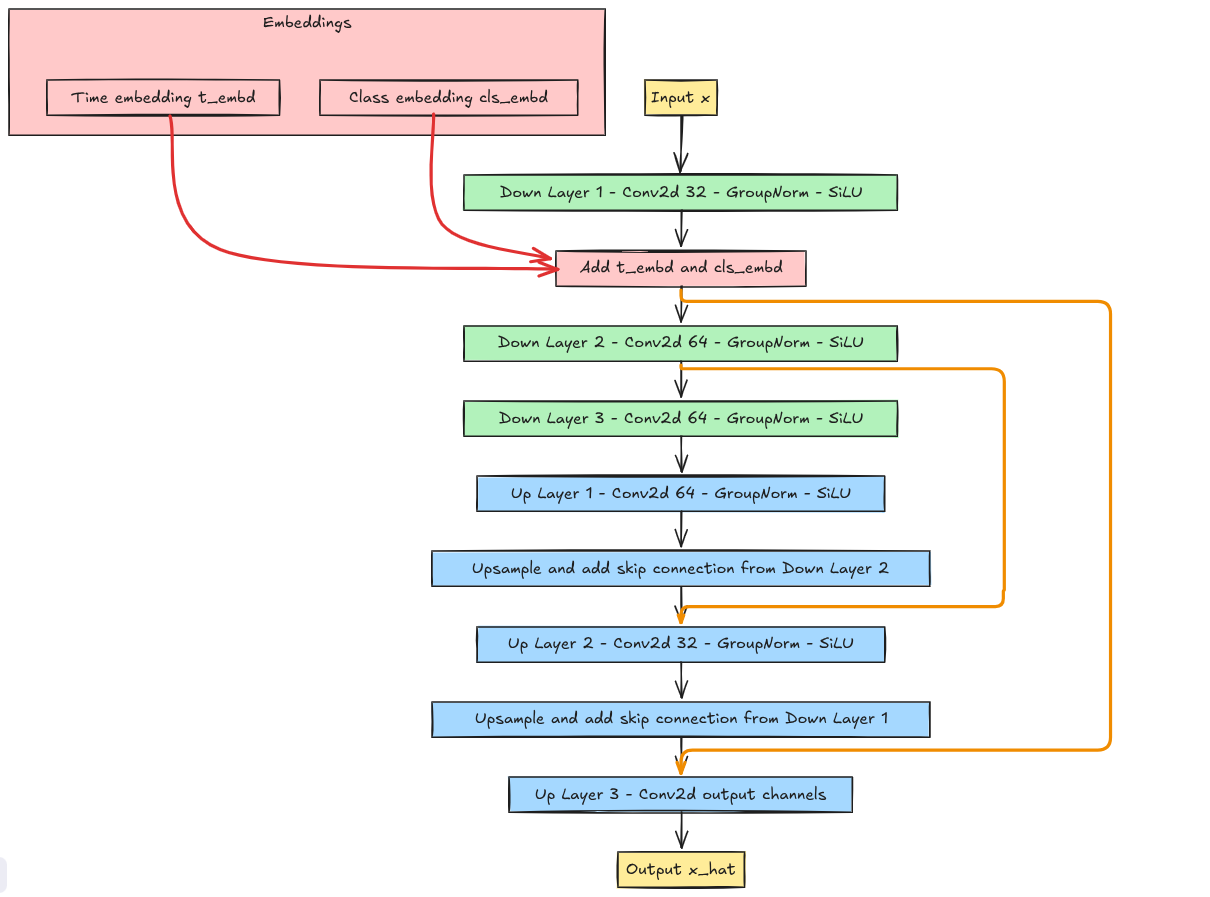

In [38]:
import torch ## import torch library 
import torch.nn as nn  ## import torch.nn module for building neural networks

class MyUNet(nn.Module): ## define a UNet class inheriting from nn.Module
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # ---- Down layers ----
        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
        ])
        
        # ---- Up layers ----
        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
                # Output layer - no normalization, no activation
            ),
        ])
        
        # ---- Embedding layers ----
        self.time_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        self.class_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        # ---- Scaling operators ----
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t, cls):
        t = t.reshape(-1, 1).to(x.device)
        cls = cls.reshape(-1, 1).to(x.device)
        
        # Embedding
        t_embd = self.time_embedding_layer(t.float())
        cls_embd = self.class_embedding_layer(cls.float())
        
        # Downsampling path
        h = []
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            if i == 0:
                x = x + t_embd[:, :, None, None] + cls_embd[:, :, None, None]
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Upsampling path
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x = x + h.pop()
            x = layer(x)
        
        return x

In [39]:
unet = MyUNet().to(device)
x=torch.randn(5,1,28,28).to(device)
t = torch.linspace(0,999,5).reshape(-1,1).to(device)
cls = torch.randperm(5).reshape(-1,1).to(device)
unet(x,t,cls).shape

torch.Size([5, 1, 28, 28])

# Train the UNet

In [40]:
def generate_image():
    xt = torch.randn(10,1,28,28).to(device)
    y = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
    
    unet.eval()

    for tt in tqdm(range(T-1,-1,-1)):
        t = torch.tensor([tt]*10)
        with torch.no_grad():
            noise_pred = unet(xt,t,y)
            
        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        alpha = alphas[t][:,None,None,None].to(device)
        beta = betas[t][:,None,None,None].to(device)
        
        
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = beta / torch.sqrt(1 - alpha_bar)
        mu_theta = coef1 * (xt - coef2 * noise_pred)
        
        if tt > 0:
            # Sample noise for the next step
            noise = torch.randn_like(xt).to(device)
            sigma_t = torch.sqrt(beta).to(device)  # or learned covariance
            xt = mu_theta + sigma_t * noise
        else:
            # At t=0, no noise added
            xt = mu_theta
    
    plt.figure(figsize=(10,3))
    plt.title(f'step:{step}')
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

In [ ]:
# sample training
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(unet.parameters(),lr=5e-4)

step=0

for epoch in range(50):
    for x,y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        unet.train()
        
        x = x.to(device)
        
        t = torch.randint(0,T,(x.shape[0],))
        
        noise = torch.randn_like(x).to(device)

        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        x_noised = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar) * noise

        pred_noise = unet(x_noised,t,y)
        
        loss_val = loss_fn(pred_noise,noise)

        loss_val.backward()
       
        optimizer.step()
        optimizer.zero_grad() 
        
        step+=1
        
    if epoch%5==0:
        generate_image()
# Sample from the model
    


  0%|          | 0/938 [00:00<?, ?it/s]

In [11]:
x_t1.max(),x_t1.min()

(tensor(3.9025, device='cuda:0'), tensor(-3.8137, device='cuda:0'))